In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow import keras
import cv2
import os
from PIL import Image
from glob import glob
import itertools
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_to_images='/content/drive/MyDrive/Medicinal Leaf Dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
data = []
def load_images_from_folder(folder):
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg','.png')):
                img_path=os.path.join(subdir, file)
                # print(img_path)
                label=os.path.basename(os.path.dirname(img_path))
                data.append((img_path, label))

load_images_from_folder(path_to_images)
df = pd.DataFrame(data, columns=['image_path', 'label'])
df

,image_path,label
0,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Tabernaemontana Divaricata (Crape Jasmine)
1,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Tabernaemontana Divaricata (Crape Jasmine)
2,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Tabernaemontana Divaricata (Crape Jasmine)
3,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Tabernaemontana Divaricata (Crape Jasmine)
4,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Tabernaemontana Divaricata (Crape Jasmine)
...,...,...
1840,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Ficus Auriculata (Roxburgh fig)
1841,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Ficus Auriculata (Roxburgh fig)
1842,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Ficus Auriculata (Roxburgh fig)
1843,/content/drive/MyDrive/Medicinal Leaf Dataset/...,Ficus Auriculata (Roxburgh fig)


No charts were generated by quickchart


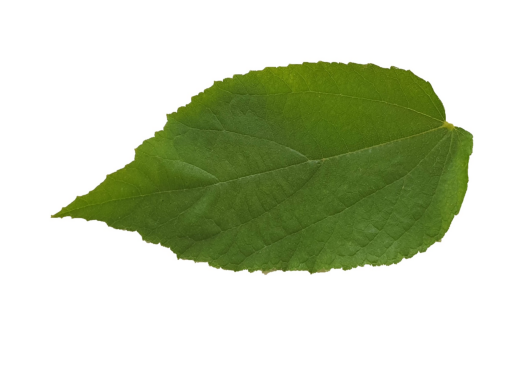

In [ ]:
import matplotlib.image as mpimg
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# pic2=df.iloc[11:12,0]
# pic2=str(pic2)
# print(type(pic2))
# display_image(pic2)
pic=df.loc[712, 'image_path']
display_image(pic)

In [ ]:
#resizing images

trainingset = []
traininglabels = []
num = len(df)
# print(num)
count = 1
for i in df.iloc[0:100,0]:
    print(str(count)+'/'+str(num),end='r')
    trainingset.append(cv2.resize(cv2.imread(i),(128,128)))
    # display_image(i)
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

1/1845r2/1845r3/1845r4/1845r5/1845r6/1845r7/1845r8/1845r9/1845r10/1845r11/1845r12/1845r13/1845r14/1845r15/1845r16/1845r17/1845r18/1845r19/1845r20/1845r21/1845r22/1845r23/1845r24/1845r25/1845r26/1845r27/1845r28/1845r29/1845r30/1845r31/1845r32/1845r33/1845r34/1845r35/1845r36/1845r37/1845r38/1845r39/1845r40/1845r41/1845r42/1845r43/1845r44/1845r45/1845r46/1845r47/1845r48/1845r49/1845r50/1845r51/1845r52/1845r53/1845r54/1845r55/1845r56/1845r57/1845r58/1845r59/1845r60/1845r61/1845r62/1845r63/1845r64/1845r65/1845r66/1845r67/1845r68/1845r69/1845r70/1845r71/1845r72/1845r73/1845r74/1845r75/1845r76/1845r77/1845r78/1845r79/1845r80/1845r81/1845r82/1845r83/1845r84/1845r85/1845r86/1845r87/1845r88/1845r89/1845r90/1845r91/1845r92/1845r93/1845r94/1845r95/1845r96/1845r97/1845r98/1845r99/1845r100/1845r

preprocessing-> Removing background,Gaussian blur,masking

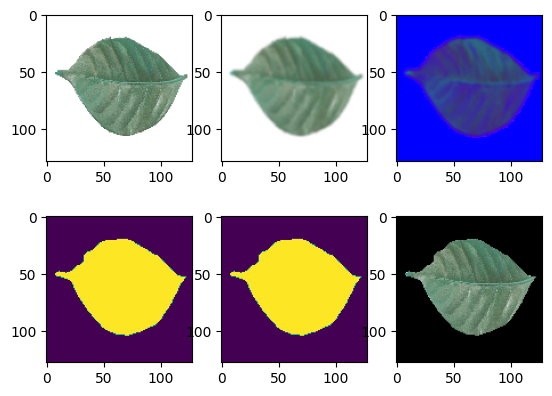

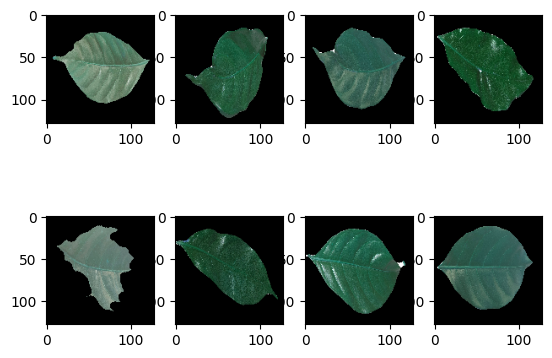

In [ ]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)
# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])


Classes: ['Pongamia Pinnata (Indian Beech)'
 'Tabernaemontana Divaricata (Crape Jasmine)']
Number of classes: 2


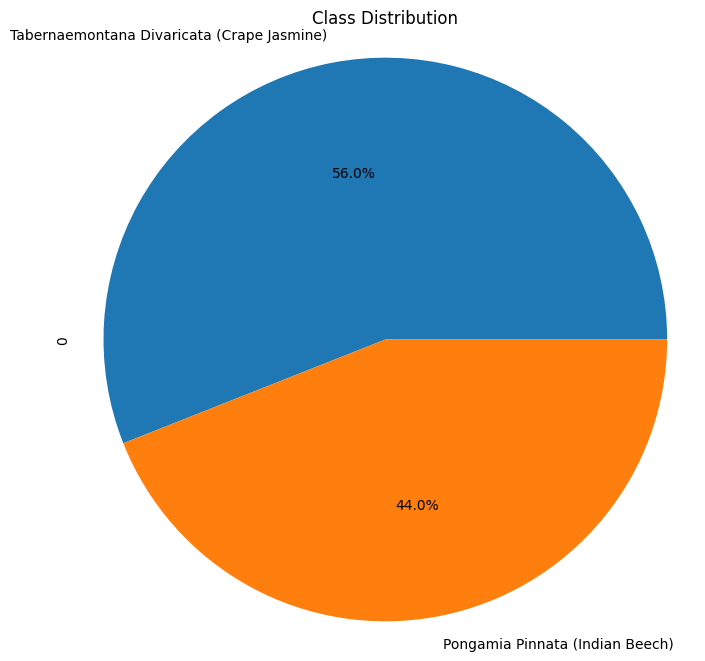

In [ ]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes: ' + str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print('Number of classes: ' + str(classes))
plt.figure(figsize=(8, 8))
traininglabels[0].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

In [ ]:
# trainingset = trainingset/255
x_train,x_test,y_train,y_test = train_test_split(trainingset,clearalllabels,test_size=0.1,stratify=clearalllabels)

preventing overfitting-> regularisation and normalisation

In [ ]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)


#**CNN MODEL**


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

# Define the path to your plant image dataset
# dataset_path = 'path/to/your/dataset'
dataset_path=path_to_images

# Define the image dimensions you want (e.g., 224x224 pixels)
img_height, img_width = 128,128

# Define the number of classes (plant species)
num_classes = len(os.listdir(dataset_path))

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Normalize pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift the width of the image
    height_shift_range=0.2,    # Randomly shift the height of the image
    horizontal_flip=True,      # Randomly flip images horizontally
    validation_split=0.2       # Split the data into training and validation sets
)

# Load and preprocess the dataset using the ImageDataGenerator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Define a CNN model for plant recognition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=1, validation_data=validation_generator)

Found 1488 images belonging to 30 classes.
Found 357 images belonging to 30 classes.
47/47 [==============================] - 1107s 23s/step - loss: 3.3751 - accuracy: 0.0726 - val_loss: 3.3095 - val_accuracy: 0.0812


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to the new plant image(s)
new_image_path = '/content/drive/MyDrive/Project_Colab Notebooks/Neem.jpg'  # Replace with the actual path to your image

# Load and preprocess the new image(s)
img = image.load_img(new_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the trained model
predictions = model.predict(img_array)

# Get the predicted class label (plant species) with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)

# Map the class index to the actual class name
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class_index[0]]

# Print the predicted class name
print(f'The predicted plant species is: {predicted_class_name}')


1/1 [==============================] - 0s 424ms/step
The predicted plant species is: Mentha (Mint)


## **RANDOM FOREST CLASSIFIER**


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
i=0
# Function to load images and labels from a folder
def load_images_from_folder(folder):
    data = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                data.append((img_path, label))
    return data

# Load images and labels
path_to_images = '/content/drive/MyDrive/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
data = load_images_from_folder(path_to_images)

# Create a DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Feature extraction (HOG in this example)
features = []
for img_path in df['image_path']:
    image = cv2.imread(img_path, 0)  # Load the image in grayscale
    image = cv2.resize(image,(256,256))
    hog_feature = cv2.HOGDescriptor().compute(image)
    features.append(hog_feature)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=42)

# Create and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7479674796747967
Classification Report:
                                               precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.93      1.00      0.97        14
            Amaranthus Viridis (Arive-Dantu)       0.73      0.83      0.78        23
        Artocarpus Heterophyllus (Jackfruit)       0.54      0.64      0.58        11
                   Azadirachta Indica (Neem)       0.71      0.62      0.67         8
                       Basella Alba (Basale)       0.58      0.64      0.61        22
            Brassica Juncea (Indian Mustard)       1.00      0.29      0.44         7
                  Carissa Carandas (Karanda)       0.86      0.95      0.90        20
                        Citrus Limon (Lemon)       0.50      0.60      0.55        10
             Ficus Auriculata (Roxburgh fig)       0.75      0.75      0.75        12
               Ficus Religiosa (Peepal Tree)       1.00      1.00      1.00        11


# **XG BOOST**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to load images and labels from a folder
def load_images_from_folder(folder):
    data = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                data.append((img_path, label))
    return data

# Load images and labels
path_to_images = '/content/drive/MyDrive/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
data = load_images_from_folder(path_to_images)
data = data[0:1000]
# Create a DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Encode labels with LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Feature extraction (HOG in this example)
features = []
for img_path in df['image_path']:
    image = cv2.imread(img_path, 0)  # Load the image in grayscale
    image = cv2.resize(image,(128,128))
    hog_feature = cv2.HOGDescriptor().compute(image)
    features.append(hog_feature)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=42)

# Create and train the XGBoost classifier
clf = xgb.XGBClassifier(random_state=42,max_depth=2,n_estimators=10)
clf.fit(np.vstack(X_train), y_train)

# Make predictions on the test data
y_pred = clf.predict(np.vstack(X_test))

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input


# Function to load images and labels from a folder
def load_images_from_folder(folder):
    data = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                data.append((img_path, label))
    return data

# Load images and labels
path_to_images = '/content/drive/MyDrive/DAA PRAC/Segmented Medicinal Leaf Images'
data = load_images_from_folder(path_to_images)

# Create a DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Split data into training, testing, and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Data augmentation for validation and testing sets (no data augmentation)
test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create and compile the CNN model (based on VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_df['label'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
num_epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=num_epochs
)

# Evaluate the CNN model on the test set
test_results = model.evaluate(test_generator, steps=len(test_generator))
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

# Predict using the CNN model
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
class_names = list(train_df['label'].unique())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout

seed = 7
np.random.seed(seed)
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      4864      
                                                                 
 batch_normalization_8 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
lrr = ReduceLROnPlateau(monitor='val_acc',
                        patience=3,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.00001)
# filepath="drive/DataScience/PlantReco/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoints = ModelCheckpoint(filepath, monitor='val_acc',
#                               verbose=1, save_best_only=True, mode='max')
# filepath="drive/DataScience/PlantReco/weights.last_auto4.hdf5"
# checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc',
#                                  verbose=1, save_best_only=False, mode='max')
# callbacks_list = [checkpoints, lrr, checkpoints_full]
#MODEL
# hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75),
#                            epochs=35, validation_data=(testX, testY),
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)
# LOADING MODEL
# model.load_weights("../input/plantrecomodels/weights.best_17-0.96.hdf5")
# dataset = np.load("../input/plantrecomodels/Data.npz")
model.fit(x_train,y_train,batch_size=75,epochs=35)
# data = dict(zip(("x_train","x_test","y_train", "y_test"), (dataset[k] for k in dataset)))
# x_train = data['x_train']
# x_test = data['x_test']
# y_train = data['y_train']
# y_test = data['y_test']
# print(model.evaluate(x_train, y_train))
# print(model.evaluate(x_test, y_test))

Epoch 1/35
2/2 [==============================] - 82s 13s/step - loss: 1.3564 - accuracy: 0.5222
Epoch 2/35
2/2 [==============================] - 74s 11s/step - loss: 0.2189 - accuracy: 0.9111
Epoch 3/35
2/2 [==============================] - 70s 13s/step - loss: 0.1001 - accuracy: 0.9556
Epoch 4/35
2/2 [==============================] - 68s 10s/step - loss: 0.1232 - accuracy: 0.9556
Epoch 5/35
2/2 [==============================] - 70s 13s/step - loss: 0.1858 - accuracy: 0.9556
Epoch 6/35
2/2 [==============================] - 69s 10s/step - loss: 0.0797 - accuracy: 0.9889
Epoch 7/35
2/2 [==============================] - 69s 13s/step - loss: 0.1248 - accuracy: 0.9667
Epoch 8/35
2/2 [==============================] - 67s 9s/step - loss: 0.0497 - accuracy: 0.9889
Epoch 9/35
2/2 [==============================] - 71s 13s/step - loss: 0.0421 - accuracy: 0.9889
Epoch 10/35
2/2 [==============================] - 67s 10s/step - loss: 0.0919 - accuracy: 0.9778
Epoch 11/35
2/2 [=============

In [ ]:
y_pred=model.predict(x_test)

1/1 [==============================] - 3s 3s/step


In [ ]:
print(y_pred)
print(y_test)

[[9.99999940e-01 0.00000000e+00]
 [7.03358054e-01 2.96641916e-01]
 [2.86409497e-01 7.13590443e-01]
 [1.89255621e-14 9.99999940e-01]
 [2.49483070e-26 9.99999940e-01]
 [9.99999940e-01 6.84217352e-33]
 [9.99999940e-01 1.95407210e-35]
 [0.00000000e+00 9.99999940e-01]
 [8.33255243e-09 1.00000000e+00]
 [1.00000000e+00 1.15202935e-23]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define file paths for saving model checkpoints
checkpoint_dir = '/content/drive/MyDrive/'

data_dir = '/content/drive/MyDrive/Medicinal Leaf Dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(70, 70),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(30, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lrr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=3,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.00001)

best_model_filepath = checkpoint_dir + 'weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoints = ModelCheckpoint(best_model_filepath, monitor='val_accuracy',
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoints, lrr]

#model training
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list
)

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')


Found 1488 images belonging to 30 classes.
Found 357 images belonging to 30 classes.
46/46 [==============================] - ETA: 0s - loss: 3.8204 - accuracy: 0.1099
Epoch 1: val_accuracy improved from -inf to 0.02273, saving model to /content/drive/MyDrive/Project_Colab Notebooks/weights.best_01-0.02.hdf5
12/12 [==============================] - 22s 2s/step - loss: 10.1498 - accuracy: 0.0280
Validation loss: 10.149760246276855, Validation accuracy: 0.028011204674839973
